# Amazon Reviews

Use one of the following datasets to perform sentiment analysis on the given Amazon reviews. Pick one of the "small" datasets that is a reasonable size for your computer. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. Try to see how these reviews compare across categories. Does a review classification model for one category work for another?

http://jmcauley.ucsd.edu/data/amazon/

Amazon product data
Julian McAuley, UCSD

New!: Repository of Recommender Systems Datasets
See a variety of other datasets for recommender systems research on our lab's dataset webpage

Description
This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).

Files
"Small" subsets for experimentation
If you're using this data for a class project (or similar) please consider using one of these smaller datasets below before requesting the larger files. To obtain the larger files you will need to contact me to obtain access.

K-cores (i.e., dense subsets): These data have been reduced to extract the k-core, such that each of the remaining users and items have k reviews each.

In [62]:
%matplotlib inline

import sqlite3
import json
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import sqlite3
import json
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

In [3]:
df = pd.read_json('Video_Games_5.json', lines=True)

In [4]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


In [5]:
df[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [6]:
#Cleaning the data by eliminating duplicates
df.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
df['% Upvote'] = pd.cut(df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df['Id'] = df.index

In [7]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000,8,12,0.666667,60-80%,0
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400,0,0,-1.000000,Empty,1
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600,0,0,-1.000000,Empty,2
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400,7,10,0.700000,60-80%,3
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,2,2,1.000000,80-100%,4


In [8]:
df = df[df['% Upvote'].isin(['0-20%', '20-50%', '50-80%', '80-100%'])]
df.shape

(64360, 14)

In [9]:
# Create mapper
scale_mapper = {'0-20%':0, '20-50%':0, '50-80%':1, '80-100%':1}

In [10]:
# Map feature values to scale
df['Upvote_class'] = df['% Upvote'].replace(scale_mapper)

In [11]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,2,2,1.000000,80-100%,4,1
6,0700099867,"[11, 13]",5,Loved playing Dirt 2 and I thought the graphic...,"08 14, 2011",AN3YYDZAS3O1Y,Bob,A step up from Dirt 2 and that is terrific!,1313280000,11,13,0.846154,80-100%,6,1
9,0700099867,"[1, 1]",2,I still haven't figured this one out. Did ever...,"02 8, 2014",A2JLT2WY0F2HVI,D. Sweetapple,Couldn't get this one to work,1391817600,1,1,1.000000,80-100%,9,1
10,0700099867,"[1, 1]",5,I'm not quite finished with the game's DiRT To...,"06 28, 2011",A38NXTZUFB1O2K,FiSH,Best in the series!,1309219200,1,1,1.000000,80-100%,10,1
15,0700099867,"[1, 1]",1,"This game was a rip-off. It has less terrain,...","07 15, 2013",A14L115LBOB0A5,MotoRider42HC,Not as good as DiRT 2,1373846400,1,1,1.000000,80-100%,15,1


In [12]:
count_class_0, count_class_1 = df.Upvote_class.value_counts()

In [14]:
# Divide by class
df_class_0 = df[df['Upvote_class'] == 0]
df_class_1 = df[df['Upvote_class'] == 1]

In [15]:
print('Class distribution:')
print('0:', len(df_class_0.axes[0]))
print('1:', len(df_class_1.axes[0]))

Class distribution:
0: 6000
1: 58360


Random under-sampling:
1    6000
0    6000
Name: Upvote_class, dtype: int64


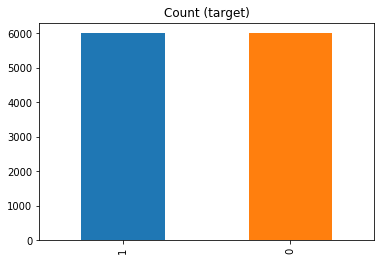

In [16]:
df_class_1_under = df_class_1.sample(count_class_1)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_under.Upvote_class.value_counts())

df_test_under.Upvote_class.value_counts().plot(kind='bar', title='Count (target)');

In [17]:
df_test_under.shape

(12000, 15)

In [18]:
#New datafram
df = df_test_under

In [19]:
df.shape

(12000, 15)

In [20]:
helpfulness = df[['helpful','asin']]

In [21]:
helpfulness.head()

,helpful,asin
75218,"[1, 1]",B000HMQE8S
90763,"[47, 51]",B000U5W0YY
11090,"[2, 2]",B00004SWKG
68752,"[1, 1]",B000FQ2DTA
89469,"[1, 1]",B000TG72TM


In [22]:
df2 = pd.DataFrame(helpfulness)

In [23]:
df2[['helpful','total']] = pd.DataFrame(df2.helpful.values.tolist(), index=df2.index)
dfhelpful = df2[['asin', 'helpful','total']]

In [24]:
dfhelpful.head()

,asin,helpful,total
75218,B000HMQE8S,1,1
90763,B000U5W0YY,47,51
11090,B00004SWKG,2,2
68752,B000FQ2DTA,1,1
89469,B000TG72TM,1,1


In [25]:
dfNew = df.drop('helpful',1)

In [26]:
frames = [dfNew, dfhelpful]

In [27]:
result = dfNew.join(dfhelpful[['helpful','total']])

In [28]:
result.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id,Upvote_class,helpful,total
75218,B000HMQE8S,2,"The graphics, controls, and sound are fine. Th...","07 6, 2013",A12LH2100CKQO,God is a refuge for us (Psalms 62:8),boring,1373068800,1,1,1.000000,80-100%,75218,1,1,1
90763,B000U5W0YY,5,Here is the review I wrote for the game after ...,"11 22, 2007",A282RNKOO2P5RT,AreYouKidding?,Fun sequel to one of the previous best,1195689600,47,51,0.921569,80-100%,90763,1,47,51
11090,B00004SWKG,5,Pure evil. Pure violence. Pure carnage. And I ...,"04 26, 2001",AAOMG1YP0VNP9,Chris 'raging bill' Burton,Its disgusting and it should be banned. Thank ...,988243200,2,2,1.000000,80-100%,11090,1,2,2
68752,B000FQ2DTA,4,"Graphics: 10/10As one would expect, this is a ...","12 26, 2010",A291KJT4SSN6VL,Amazon Customer,"Not a Classic of the Series, but still good",1293321600,1,1,1.000000,80-100%,68752,1,1,1
89469,B000TG72TM,5,"This game is as good as advertised. I mean, th...","04 20, 2008",A1JBP1MKGLWDRP,1Dub79,As Good As Advertised,1208649600,1,1,1.000000,80-100%,89469,1,1,1


In [29]:
result.to_csv('reviews.csv', sep=',', header=False,index=False)

In [30]:
result.shape

(12000, 16)

In [31]:
#use SQLite
result.columns

Index(['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Helpful %', '% Upvote', 'Id', 'Upvote_class',
       'helpful', 'total'],
      dtype='object')

In [32]:
class csvrd(object):
    def csvFile(self):

        self.readFile('reviews.csv')

    def readFile(self, filename):
        conn = sqlite3.connect('amazonReviews.db')
        cur = conn.cursor() 
        cur.execute("""CREATE TABLE IF NOT EXISTS amazonReviews(asin INT,overall INT,reviewText varchar,reviewTime INTEGER, reviewerID varchar,reviewerName varchar,summary varchar,unixReviewTime INTEGER,HelpfulnessNumerator INTEGER,HelpfulnessDenominator INTEGER,Helpful_PC INTEGER,Upvote_PC CATEGORY,Id INTEGER,Upvote_class INTEGER,helpful INT,total INT)""")
        filename.encode('utf-8')
        print("Amazon Reviews table executed")
        with open(filename) as f:
            reader = csv.reader(f)
            for field in reader:
                cur.execute("INSERT INTO amazonReviews VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);", field)

        print("CSV Loaded into SQLite")
        conn.commit()
        conn.close()

c = csvrd().csvFile()

Amazon Reviews table executed
CSV Loaded into SQLite


In [33]:
con = sqlite3.connect('amazonReviews.db')

pd.read_sql_query("SELECT * FROM amazonReviews LIMIT 5", con)

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful_PC,Upvote_PC,Id,Upvote_class,helpful,total
0,B000HMQE8S,2,"The graphics, controls, and sound are fine. Th...","07 6, 2013",A12LH2100CKQO,God is a refuge for us (Psalms 62:8),boring,1373068800,1,1,1.000000,80-100%,75218,1,1,1
1,B000U5W0YY,5,Here is the review I wrote for the game after ...,"11 22, 2007",A282RNKOO2P5RT,AreYouKidding?,Fun sequel to one of the previous best,1195689600,47,51,0.921569,80-100%,90763,1,47,51
2,B00004SWKG,5,Pure evil. Pure violence. Pure carnage. And I ...,"04 26, 2001",AAOMG1YP0VNP9,Chris 'raging bill' Burton,Its disgusting and it should be banned. Thank ...,988243200,2,2,1.000000,80-100%,11090,1,2,2
3,B000FQ2DTA,4,"Graphics: 10/10As one would expect, this is a ...","12 26, 2010",A291KJT4SSN6VL,Amazon Customer,"Not a Classic of the Series, but still good",1293321600,1,1,1.000000,80-100%,68752,1,1,1
4,B000TG72TM,5,"This game is as good as advertised. I mean, th...","04 20, 2008",A1JBP1MKGLWDRP,1Dub79,As Good As Advertised,1208649600,1,1,1.000000,80-100%,89469,1,1,1


In [34]:
reviews = pd.read_sql_query("""
SELECT 
  overall, 
  summary, 
  helpful, 
  total
FROM amazonReviews 
WHERE overall != 3""", con)

In [35]:
reviews.head()

,overall,summary,helpful,total
0,2,boring,1,1
1,5,Fun sequel to one of the previous best,47,51
2,5,Its disgusting and it should be banned. Thank ...,2,2
3,4,"Not a Classic of the Series, but still good",1,1
4,5,As Good As Advertised,1,1


In [36]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: "useful" if n > 0.8 else "useless")

reviews.head(5)

,overall,summary,helpful,total,sentiment,usefulScore
0,2,boring,1,1,negative,useful
1,5,Fun sequel to one of the previous best,47,51,positive,useful
2,5,Its disgusting and it should be banned. Thank ...,2,2,positive,useful
3,4,"Not a Classic of the Series, but still good",1,1,positive,useful
4,5,As Good As Advertised,1,1,positive,useful


In [37]:
#Rows having overall score equal to 5
reviews[reviews.overall == 5].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
1,5,Fun sequel to one of the previous best,47,51,positive,useful
2,5,Its disgusting and it should be banned. Thank ...,2,2,positive,useful
4,5,As Good As Advertised,1,1,positive,useful
5,5,Chrono Trigger........,3,3,positive,useful
6,5,"This is not the color I received, but happy no...",1,1,positive,useful


In [38]:
#Rows having overall score equal to 1
reviews[reviews.overall == 1].head(5)

,overall,summary,helpful,total,sentiment,usefulScore
34,1,apparently you can polish a turd,2,2,negative,useful
55,1,"Updated review, 11/9/12",3,3,negative,useful
100,1,Frame rate is horrendous,1,1,negative,useful
139,1,"Et tu, CA?",9,10,negative,useful
151,1,not good,15,18,negative,useful


In [39]:
reviews.shape

(10508, 6)

In [41]:
#Feature extraction
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

reviews["summaryClean"] = reviews["summary"].apply(cleanReviews)

train, test = train_test_split(reviews, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

8406 items in training data, 2102 in test data


In [42]:
train.head()

,overall,summary,helpful,total,sentiment,usefulScore,summaryClean
10028,1,"WORST DESIGN OF CONTROLLER, EVER",2,17,negative,useless,worst design of controller ever
3730,4,A Fun Challenge That Will Last a Long Time,2,2,positive,useful,a fun challenge that will last a long time
5122,5,A Fan's a Must-Have for XBox 360 Owners,11,11,positive,useful,a fan s a must have for xbox owners
5619,1,A worthless piece of garbage,3,65,negative,useless,a worthless piece of garbage
1870,4,Old School Mario at it's Best,2,2,positive,useful,old school mario at it s best


## Model fitting

In [46]:
#Multinomial Naive Bayes Model

model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [47]:
#Bernoulli Naive Bayes Model
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [48]:
#Logistic Regression Model
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

C:\Users\Mike\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


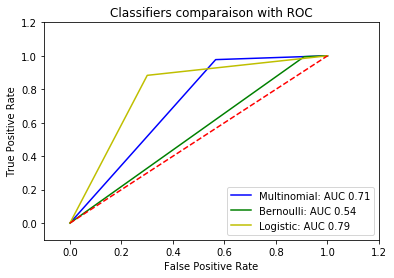

In [49]:
#Results
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
# Visualize the accuracy, recall and f1-score for Logistic Regression
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.78      0.70      0.74       783
    negative       0.83      0.88      0.86      1319

   micro avg       0.81      0.81      0.81      2102
   macro avg       0.81      0.79      0.80      2102
weighted avg       0.81      0.81      0.81      2102



In [51]:
accuracy_score(y_test, prediction['Logistic'])

0.8149381541389153

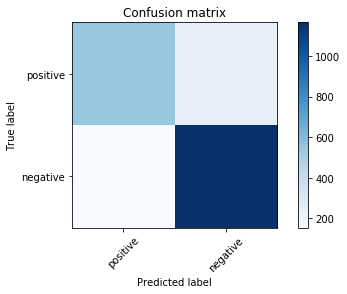

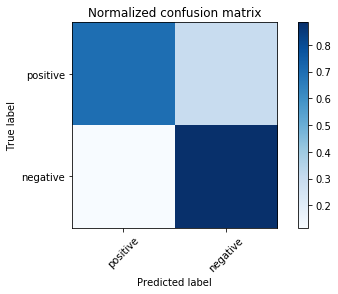

In [52]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

In [53]:
# Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.91      0.09      0.16       783
    negative       0.65      0.99      0.78      1319

   micro avg       0.66      0.66      0.66      2102
   macro avg       0.78      0.54      0.47      2102
weighted avg       0.75      0.66      0.55      2102



In [55]:
accuracy_score(y_test, prediction['Bernoulli'])

0.6579448144624167

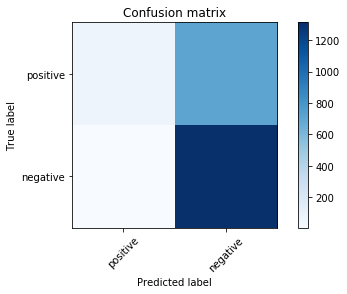

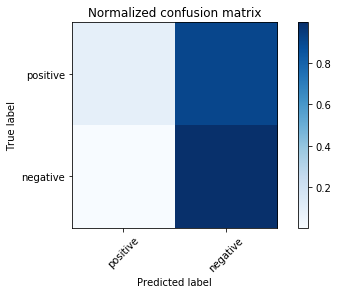

In [56]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Bernoulli'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

In [57]:
# Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.92      0.43      0.59       783
    negative       0.74      0.98      0.84      1319

   micro avg       0.77      0.77      0.77      2102
   macro avg       0.83      0.71      0.72      2102
weighted avg       0.81      0.77      0.75      2102



In [58]:
accuracy_score(y_test, prediction['Multinomial'])

0.774976213130352

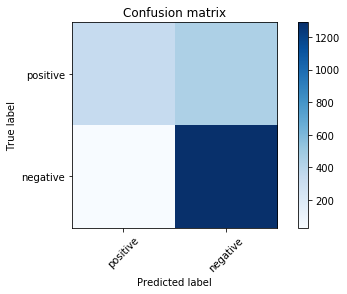

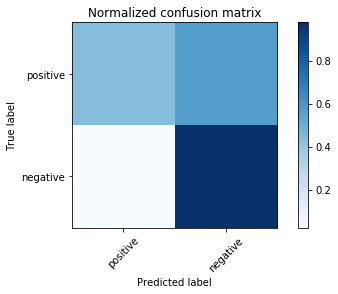

In [59]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

In [60]:
#Words of best and worst featurers
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
63548,worst,-40.584419
38090,not,-33.893295
7569,boring,-31.638381
23413,good but,-28.725940
52230,terrible,-26.950877
38837,not worth,-24.027932
13662,disappointment,-24.004023
51430,sucks,-23.830643
43658,poor,-23.388768
24543,great game,-22.729517


In [61]:
#Sentiments
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "Could have been better.")
testSentiments(logreg, "Just what we expected.")
testSentiments(logreg, "Great, we enjoyed it with my dog!")

Sample estimated as NEGATIVE: negative prob 0.997835, positive prob 0.002165
Sample estimated as NEGATIVE: negative prob 0.776848, positive prob 0.223152
Sample estimated as POSITIVE: negative prob 0.000004, positive prob 0.999996
